Automação de preenchimento de tabelas e geração de gráficos

O script faz o scraping de dados sobre inflação, preço do petróleo e diesel, gerando gráficos e preenchendo tabelas utilizadas no Boletim Econômico e Regulatório da AGEPAR.

*Autor: Matheus Brasil*

## pacotes

In [137]:
import pandas as pd             # manipulação dos dados tabulares e scraping
import numpy as np              # manipulação séries temporais
import ssl                      # conexão de segurança http
import datetime as dt           # manipulação de objetos com data
import urllib                   # pacote para requerimento de download
import matplotlib.pyplot as plt # pacote para criar gráficos
import openpyxl as oxl          # pacote para manipulação de arquivos .xlsx (preenchimento)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates

## Dados

### Scraping do ipca, inpc, igpdi, igpm e brent na página do ipeadata

In [138]:
ssl._create_default_https_context = ssl._create_unverified_context

url_brent = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?stub=1&serid1650971490=1650971490&PerID=1&PerMetodo1650971490_0=LST&module=M'
url_ipca = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=36482'
url_inpc = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=36472'
url_igpdi = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=33593'
url_igpm = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?serid=37796'

pagina_brent = pd.read_html(url_brent)
pagina_ipca = pd.read_html(url_ipca)
pagina_inpc = pd.read_html(url_inpc)
pagina_igpdi = pd.read_html(url_igpdi)
pagina_igpm = pd.read_html(url_igpm)

### Download da série histórica dos combustíveis de 2018 a 2021 e 2022

In [ ]:
serie_hist_mun_22 = 'https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-municipios-2022.xlsx'
download22 = urllib.request.urlretrieve(serie_hist_mun_22, 'dados/precos_semanal_22.xlsx')

serie_hist_mun_18a21 = 'https://www.gov.br/anp/pt-br/assuntos/precos-e-defesa-da-concorrencia/precos/precos-revenda-e-de-distribuicao-combustiveis/shlp/semanal/semanal-municipios-2018-a-2021.xlsb'
download18a21 = urllib.request.urlretrieve(serie_hist_mun_18a21, 'dados/precos_semanal_18a21.csv')

### Importação dos Itens e Subitens IPCA e INPC

In [141]:
ipca_subitem_atual = pd.ExcelFile('dados/ipca_subitem_atual.xls')                       #Importa arquivo excel completo
ipca_subitem_mensal_atual = pd.read_excel(ipca_subitem_atual, 'MENSAL SUBITEM IPCA')    #Lê a planilha referente a variação mensal
ipca_subitem_acum_atual = pd.read_excel(ipca_subitem_atual, 'ACUM SUBITEM IPCA')        #Lê a planilha referente ao acumulado
ipca_subitem_acum12m_atual = pd.read_excel(ipca_subitem_atual, 'ACUM 12M SUBITEM IPCA') #Lê a planilha referente ao acum 12 meses
ipca_subitem_pesos_atual = pd.read_excel(ipca_subitem_atual, 'PESOS SUBITEM IPCA')      #Lê a planilha referente ao peso dos itens

ipca_subitem_anterior = pd.ExcelFile('dados/ipca_subitem_anterior.xls') 
ipca_subitem_mensal_anterior = pd.read_excel(ipca_subitem_anterior, 'MENSAL SUBITEM IPCA')    #Lê a planilha referente a variação mensal

inpc_subitem_atual = pd.ExcelFile('dados/inpc_subitem_atual.xls')                       #Importa arquivo excel completo
inpc_subitem_mensal_atual = pd.read_excel(inpc_subitem_atual, 'MENSAL SUBITEM INPC')    #Lê a planilha referente a variação mensal
inpc_subitem_acum_atual = pd.read_excel(inpc_subitem_atual, 'ACUM SUBITEM INPC')        #Lê a planilha referente ao acumulado
inpc_subitem_acum12m_atual = pd.read_excel(inpc_subitem_atual, 'ACUM 12M SUBITEM INPC') #Lê a planilha referente ao acum 12 meses
inpc_subitem_pesos_atual = pd.read_excel(inpc_subitem_atual, 'PESOS SUBITEM INPC')      #Lê a planilha referente ao peso dos itens

inpc_subitem_acum_anterior = pd.ExcelFile('dados/inpc_subitem_anterior.xls')                       #Importa arquivo excel completo
inpc_subitem_mensal_anterior = pd.read_excel(inpc_subitem_acum_anterior, 'MENSAL SUBITEM INPC')    #Lê a planilha referente a variação mensal


### Consulta da PTAX no SISBACEN

In [142]:
def consulta_bc(codigo_bcb): #Função para Realizar consulta através do código da série
  url = f'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{codigo_bcb}/dados?formato=json'
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  #df.set_index('data', inplace=True)
  return df

In [143]:
dolar = consulta_bc(10813) # Taxa de câmbio - Livre - Dólar americano (compra) - Fim de período - mensal 

In [144]:
dolar['data'] = dolar['data'].apply(lambda x: x.strftime('%m-%Y')) 

## Tratamento

### brent

In [146]:
brent = pagina_brent[2]
brent.columns = ['Data','Preço - Brent (FOB)']
brent = brent.drop(0)
brent['Preço - Brent (FOB)'] = pd.to_numeric(brent['Preço - Brent (FOB)'])
brent['Preço - Brent (FOB)'] = brent['Preço - Brent (FOB)']/100
brent['Data'] = pd.to_datetime(brent['Data'])
brent.set_index('Data', inplace=True)

### IPCA

In [147]:
ipca = pagina_ipca[2]
ipca.columns = ['Data','IPCA Indice']
ipca = ipca.drop(range(0,105))
data = ipca['Data']
ipca['IPCA Indice'] = ipca['IPCA Indice'].str.replace('.','')
ipca['IPCA Indice'] = ipca['IPCA Indice'].str.replace(',','.')
ipca['IPCA Indice'] = pd.to_numeric(ipca['IPCA Indice'])
ipca['Data'] = pd.to_datetime(ipca['Data'])
ipca.set_index('Data', inplace=True)

ipca['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    ipca['Variação Mensal'][i] = ((ipca['IPCA Indice'][i] / ipca['IPCA Indice'][i-1]) - 1)*100

ipca['Acumulado 12 meses'] = 0.0
for i in range(-1, -201, -1):
    ipca['Acumulado 12 meses'][i] = ((ipca['IPCA Indice'][i] / ipca['IPCA Indice'][i-12]) - 1)*100

ipca['Acumulado no Ano'] = 0.0
for i in range(401, len(ipca)):
    ipca['Acumulado no Ano'][i] = (ipca['IPCA Indice'][i] / ipca['IPCA Indice'][400] - 1)*100

ipca = ipca.round(2)


C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19096\2857183068.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ipca['IPCA Indice'] = ipca['IPCA Indice'].str.replace('.','')


### INPC

In [148]:
inpc = pagina_inpc[2]
inpc.columns = ['Data','INPC Indice']
inpc = inpc.drop(range(0,105))

inpc['INPC Indice'] = inpc['INPC Indice'].str.replace('.','')
inpc['INPC Indice'] = inpc['INPC Indice'].str.replace(',','.')
inpc['INPC Indice'] = pd.to_numeric(inpc['INPC Indice'])
inpc['Data'] = pd.to_datetime(inpc['Data'])
inpc.set_index('Data', inplace=True)

inpc['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    inpc['Variação Mensal'][i] = ((inpc['INPC Indice'][i] / inpc['INPC Indice'][i-1]) - 1)*100

inpc['Acumulado 12 meses'] = 0.0
for i in range(-1, -201, -1):
    inpc['Acumulado 12 meses'][i] = ((inpc['INPC Indice'][i] / inpc['INPC Indice'][i-12]) - 1)*100

inpc['Acumulado no Ano'] = 0.0
for i in range(410, len(inpc)):
    inpc['Acumulado no Ano'][i] = (inpc['INPC Indice'][i] / inpc['INPC Indice'][409] - 1)*100

inpc = inpc.round(2)


C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19096\124349729.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  inpc['INPC Indice'] = inpc['INPC Indice'].str.replace('.','')


### Itens e Subitens do IPCA e INPC

In [149]:
#IPCA
ipca_subitem_mensal_atual.iloc[3][0]='ITENS'
ipca_subitem_acum_atual.iloc[3][0]='ITENS'
ipca_subitem_acum12m_atual.iloc[3][0]='ITENS'
ipca_subitem_pesos_atual.iloc[3][0]='ITENS'

ipca_subitem_mensal_atual.columns = ipca_subitem_mensal_atual.iloc[3]
ipca_subitem_acum_atual.columns = ipca_subitem_mensal_atual.iloc[3]
ipca_subitem_acum12m_atual.columns = ipca_subitem_mensal_atual.iloc[3]
ipca_subitem_pesos_atual.columns = ipca_subitem_mensal_atual.iloc[3]

ipca_subitem_mensal_atual.reset_index(inplace=True)
ipca_subitem_acum_atual.reset_index(inplace=True)
ipca_subitem_acum12m_atual.reset_index(inplace=True)
ipca_subitem_pesos_atual.reset_index(inplace=True)

ipca_subitem_mensal_atual.drop([0,1,2,3,4], inplace=True)
ipca_subitem_acum_atual.drop([0,1,2,3,4], inplace=True)
ipca_subitem_acum12m_atual.drop([0,1,2,3,4], inplace=True)
ipca_subitem_pesos_atual.drop([0,1,2,3,4], inplace=True)

ipca_subitem_mensal_anterior.iloc[3][0]='ITENS'
ipca_subitem_mensal_anterior.columns = ipca_subitem_mensal_anterior.iloc[3]
ipca_subitem_mensal_anterior.reset_index(inplace=True)
ipca_subitem_mensal_anterior.drop([0,1,2,3,4], inplace=True)

#INPC
inpc_subitem_mensal_atual.iloc[3][0]='ITENS'
inpc_subitem_acum_atual.iloc[3][0]='ITENS'
inpc_subitem_acum12m_atual.iloc[3][0]='ITENS'
inpc_subitem_pesos_atual.iloc[3][0]='ITENS'

inpc_subitem_mensal_atual.columns = inpc_subitem_mensal_atual.iloc[3]
inpc_subitem_acum_atual.columns = inpc_subitem_mensal_atual.iloc[3]
inpc_subitem_acum12m_atual.columns = inpc_subitem_mensal_atual.iloc[3]
inpc_subitem_pesos_atual.columns = inpc_subitem_mensal_atual.iloc[3]

inpc_subitem_mensal_atual.reset_index(inplace=True)
inpc_subitem_acum_atual.reset_index(inplace=True)
inpc_subitem_acum12m_atual.reset_index(inplace=True)
inpc_subitem_pesos_atual.reset_index(inplace=True)

inpc_subitem_mensal_atual.drop([0,1,2,3,4], inplace=True)
inpc_subitem_acum_atual.drop([0,1,2,3,4], inplace=True)
inpc_subitem_acum12m_atual.drop([0,1,2,3,4], inplace=True)
inpc_subitem_pesos_atual.drop([0,1,2,3,4], inplace=True)

inpc_subitem_mensal_anterior.iloc[3][0]='ITENS'
inpc_subitem_mensal_anterior.columns = inpc_subitem_mensal_anterior.iloc[3]
inpc_subitem_mensal_anterior.reset_index(inplace=True)
inpc_subitem_mensal_anterior.drop([0,1,2,3,4], inplace=True)

### IGP-DI

In [150]:
igpdi = pagina_igpdi[2]
igpdi.columns = ['Data','IGP-DI Indice']
igpdi = igpdi.drop(range(0,105))

igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace(',','.')
igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace('.','')
igpdi['IGP-DI Indice'] = pd.to_numeric(igpdi['IGP-DI Indice']) / 10000
igpdi['Data'] = pd.to_datetime(igpdi['Data'])
igpdi.set_index('Data', inplace=True)

igpdi['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    igpdi['Variação Mensal'][i] = ((igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][i-1]) - 1)*100

igpdi['Acumulado 12 meses'] = 0.0
for i in range(-1, -100, -1):
    igpdi['Acumulado 12 meses'][i] = ((igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][i-12]) - 1)*100

igpdi['Acumulado no Ano'] = 0.0
for i in range(832, len(igpdi)):
    igpdi['Acumulado no Ano'][i] = (igpdi['IGP-DI Indice'][i] / igpdi['IGP-DI Indice'][831] - 1)*100

igpdi = igpdi.round(2)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19096\1871963093.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  igpdi['IGP-DI Indice'] = igpdi['IGP-DI Indice'].str.replace('.','')


### IGP-M

In [151]:
igpm = pagina_igpm[2]
igpm.columns = ['Data','IGP-M Indice']
igpm = igpm.drop(range(0,3))

igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace(',','.')
igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace('.','')
igpm['IGP-M Indice'] = pd.to_numeric(igpm['IGP-M Indice']) / 10000
igpm['Data'] = pd.to_datetime(igpm['Data'])
igpm.set_index('Data', inplace=True)

igpm['Variação Mensal'] = 0.0
for i in range(-1, -21, -1):
    igpm['Variação Mensal'][i] = ((igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][i-1]) - 1)*100

igpm['Acumulado 12 meses'] = 0.0
for i in range(-1, -100, -1):
    igpm['Acumulado 12 meses'][i] = ((igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][i-12]) - 1)*100

igpm['Acumulado no Ano'] = 0.0
for i in range(390, len(igpm)):
    igpm['Acumulado no Ano'][i] = (igpm['IGP-M Indice'][i] / igpm['IGP-M Indice'][389] - 1)*100

igpm = igpm.round(2)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19096\2338524234.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  igpm['IGP-M Indice'] = igpm['IGP-M Indice'].str.replace('.','')


### Diesel S10

In [152]:
precos_semanal_22 = pd.read_excel('dados/precos_semanal_22.xlsx', skiprows=11)

BadZipFile: File is not a zip file

In [ ]:
precos_semanal_18a21 = pd.read_excel('dados/precos_semanal_18a21.csv', skiprows=13)

Conversão das colunas de data para o formato datetime

In [ ]:
precos_semanal_22['DATA INICIAL'] = pd.to_datetime(precos_semanal_22['DATA INICIAL'])
precos_semanal_22['DATA FINAL'] = pd.to_datetime(precos_semanal_22['DATA FINAL'])

In [ ]:
precos_semanal_18a21['DATA INICIAL'] = pd.to_datetime(precos_semanal_18a21['DATA INICIAL'], unit='D', origin=pd.Timestamp('1900-01-01'))
precos_semanal_18a21['DATA FINAL'] = pd.to_datetime(precos_semanal_18a21['DATA FINAL'], unit='D', origin=pd.Timestamp('1900-01-01'))

In [ ]:
precos_combustiveis = pd.concat([precos_semanal_18a21, precos_semanal_22])

### Dólar

In [ ]:
dolar.set_index('data', True)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_19096\2456164757.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  dolar.set_index('data', True)


,valor
data,
1984-11-28,2814.0000
1984-11-29,2814.0000
1984-11-30,2867.0000
1984-12-03,2867.0000
1984-12-04,2867.0000
...,...
2022-06-21,5.1456
2022-06-22,5.1503
2022-06-23,5.1827


In [157]:
dolar_mensal = pd.DataFrame(dolar.groupby(pd.Grouper(freq='M'))['valor'].mean())


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

## Gráficos

### IPCA

#### Acumulado 12 meses e variação mensal

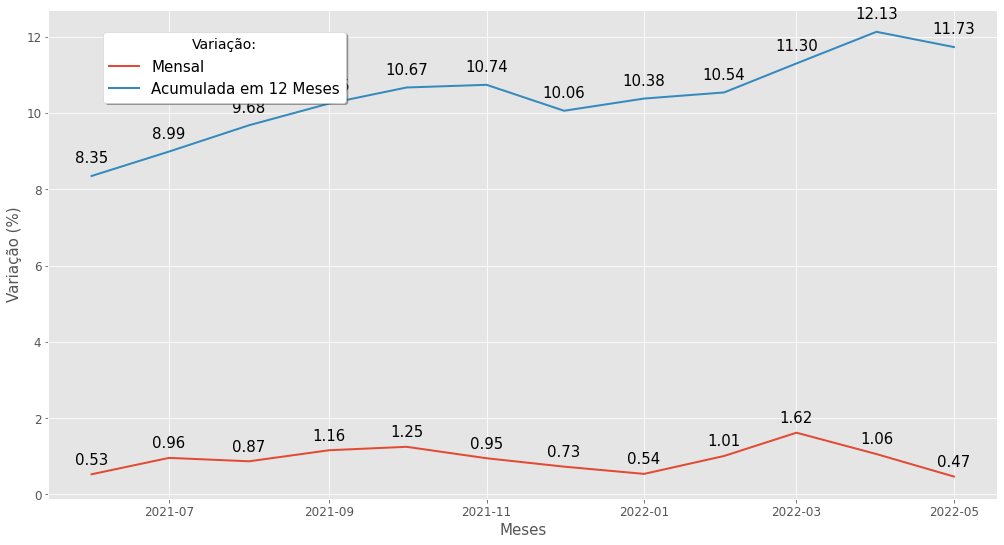

In [ ]:
ipca.iloc[-12:,[1,2]]
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(ipca.iloc[-12:,[1]], label = 'Mensal', linewidth=2)
fig.plot(ipca.iloc[-12:,[2]], label = 'Acumulada em 12 Meses', linewidth=2)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.05,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
# Valores em cada ponto do gráfico
for x,y in zip(ipca['Variação Mensal'][-12:].index,ipca['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

for x,y in zip(ipca['Acumulado 12 meses'][-12:].index,ipca['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 1 - IPCA 12M E MENSAL.svg', dpi=600)

#### Acumulado no Ano

In [ ]:
aux_data = pd.DataFrame({'data':pd.date_range('jan-2022', periods=12, freq='M'), 'Values': range(1, 13)}) #variável auxiliar para criar meses futuros no gráfico da variação acumulada.

In [ ]:
aux_data.set_index('data', inplace=True)

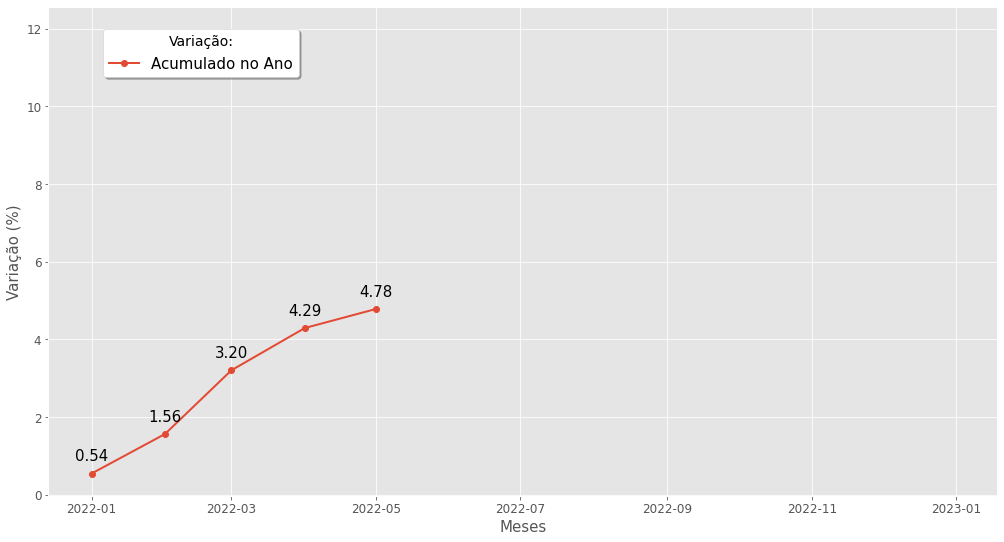

In [ ]:
ipca.iloc[-12:,[3]]

plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(ipca.iloc[401:,[3]], marker='.', markersize=12, label = 'Acumulado no Ano', linewidth=2)
fig.plot(aux_data, alpha=0)
#fig.set_title('Variação Acumulado no Ano do IPCA')
plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.05,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(ipca['Acumulado no Ano'][-12:].index,ipca['Acumulado no Ano'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center
plt.savefig('graficos/GRÁFICO 2 - IPCA NO ANO.svg', dpi=600)

### IPCA Regiões

Seleciona somente as linha com a variação regional, inverte, e renomeia as colunas

In [ ]:
regioes_dict = {
"RJ":'Rio de Janeiro',	
"POA":'Porto Alegre',
"BH":"Belo Horizonte",
"REC":"Recife",
"SP":"São Paulo",
"DF":"Brasília",
"BEL":"Belém",
"FOR":"Forteleza",
"SAL":"Salvador",
"CUR":"Curitiba",
"GOI":"Goiânia",
"VIT":"Vitória",
"CG":"Campo Grande",
"RB":"Rio Branco",
"SL":"São Luís",
"AJU":"Aracaju",
"NACIONAL":"Brasil"
}

In [ ]:
pesos = [['RJ','POA','BH','REC','SP','DF','BEL','FOR','SAL','CUR','GOI','VIT','CG','RB','SL','AJU','NACIONAL'],
[9.42, 8.61, 9.69, 3.92, 32.28, 4.06, 3.94, 3.23, 5.99, 8.09, 4.17, 1.86, 1.57, 0.51, 1.62, 1.03, 100]]
regioes_ipca_peso_atual = pd.DataFrame(pesos)
regioes_ipca_peso_atual = regioes_ipca_peso_atual.transpose()
regioes_ipca_peso_atual.columns = ['Regiao','Peso']

In [ ]:
regioes_ipca_var_anterior = ipca_subitem_mensal_anterior[ipca_subitem_mensal_anterior.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_ipca_var_atual = ipca_subitem_mensal_atual[ipca_subitem_mensal_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_ipca_acum_atual = ipca_subitem_acum_atual[ipca_subitem_acum_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_ipca_var_anterior = regioes_ipca_var_anterior.transpose().reset_index()
regioes_ipca_var_anterior.rename(columns={3:'Regiao',5:'Var ant'}, inplace=True)
regioes_ipca_var_anterior.drop(range(0,2), inplace=True)

In [ ]:
regioes_ipca_var_atual = regioes_ipca_var_atual.transpose().reset_index()
regioes_ipca_var_atual.rename(columns={3:'Regiao',5:'Var atual'}, inplace=True)
regioes_ipca_var_atual.drop(range(0,2), inplace=True)

In [ ]:
regioes_ipca_acum_atual = regioes_ipca_acum_atual.transpose().reset_index()
regioes_ipca_acum_atual.rename(columns={3:'Regiao',5:'Var acum'}, inplace=True)
regioes_ipca_acum_atual.drop(range(0,2), inplace=True)

In [ ]:
regioes_ipca_12m_atual = ipca_subitem_acum12m_atual[ipca_subitem_acum12m_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_ipca_12m_atual = regioes_ipca_12m_atual.transpose().reset_index()
regioes_ipca_12m_atual.rename(columns={3:'Regiao',5:'Var 12m'}, inplace=True)
regioes_ipca_12m_atual.drop(range(0,2), inplace=True)

Concatena as colunas com as variações


In [ ]:
subitens_regioes_ipca = pd.merge(regioes_ipca_var_anterior, regioes_ipca_var_atual, how='outer')

In [ ]:
subitens_regioes_ipca = pd.merge(subitens_regioes_ipca, regioes_ipca_acum_atual, how='outer')

In [ ]:
subitens_regioes_ipca = pd.merge(subitens_regioes_ipca, regioes_ipca_12m_atual, how='outer')

In [ ]:
subitens_regioes_ipca = pd.merge(subitens_regioes_ipca, regioes_ipca_peso_atual, how='outer')

In [ ]:
subitens_regioes_ipca['Regiao'] = [regioes_dict[resp] for resp in subitens_regioes_ipca.Regiao]

In [ ]:
linha_brasil = subitens_regioes_ipca[subitens_regioes_ipca['Regiao'] == 'Brasil']

In [ ]:
subitens_regioes_ipca.drop(16, inplace=True)

In [ ]:
subitens_regioes_ipca.sort_values('Var atual', ascending=False, inplace=True)

In [ ]:
subitens_regioes_ipca = pd.concat([subitens_regioes_ipca, linha_brasil])

In [ ]:
subitens_regioes_ipca

,Regiao,Var ant,Var atual,Var acum,Var 12m,Peso
14,São Luís,0.54,1.33,1.88,10.72,1.62
0,Rio de Janeiro,0.6,1.32,1.94,10.06,9.42
9,Curitiba,0.47,1.28,1.76,13.17,8.09
15,Aracaju,0.9,1.26,2.18,10.94,1.03
2,Belo Horizonte,0.8,1.07,1.88,10.47,9.69
12,Campo Grande,0.62,1.06,1.68,11.18,1.57
4,São Paulo,0.63,1.05,1.69,10.26,32.28
3,Recife,0.41,0.97,1.38,10.53,3.92
6,Belém,0.65,0.97,1.62,8.37,3.94
5,Brasília,0.49,0.93,1.43,9.55,4.06


In [ ]:
workbook = oxl.load_workbook(filename='tabela_regioes.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do ipca de curitiba
for i in range(0, 17):
    sheet[f"B{i+4}"] = subitens_regioes_ipca.iloc[i,5]
    sheet[f"A{i+4}"] = subitens_regioes_ipca.iloc[i,0]
    sheet[f"C{i+4}"] = subitens_regioes_ipca.iloc[i,1]
    sheet[f"D{i+4}"] = subitens_regioes_ipca.iloc[i,2]
    sheet[f"E{i+4}"] = subitens_regioes_ipca.iloc[i,3]
    sheet[f"F{i+4}"] = subitens_regioes_ipca.iloc[i,4]


In [ ]:
workbook.save(filename="tabelas\IPCA REGIÕES.xlsx")

### IPCA Curitiba

Data frame com variação mensal. Ordenado do maior para o menor e possui a coluna que vai ser referencia

In [ ]:
ipca_cur_mensal_anterior = ipca_subitem_mensal_anterior[ipca_subitem_mensal_anterior.index.isin([6, 194, 234, 275, 317, 350, 396, 426, 451])]

In [ ]:
ipca_cur_mensal_atual = ipca_subitem_mensal_atual[ipca_subitem_mensal_atual.index.isin([6, 194, 234, 275, 317, 350, 396, 426, 451])]

In [ ]:
ipca_cur_acum_atual = ipca_subitem_acum_atual[ipca_subitem_acum_atual.index.isin([6, 194, 234, 275, 317, 350, 396, 426, 451])]

In [ ]:
ipca_cur_acum12m_atual = ipca_subitem_acum12m_atual[ipca_subitem_acum12m_atual.index.isin([6, 194, 234, 275, 317, 350, 396, 426, 451])]

renomear colunas

In [ ]:
ipca_cur_mensal_anterior.rename(columns={'CUR':'CUR VAR ANT'}, inplace=True)
ipca_cur_mensal_atual.rename(columns={'CUR':'CUR VAR'}, inplace=True)
ipca_cur_acum_atual.rename(columns={'CUR':'CUR ACUM'}, inplace=True)
ipca_cur_acum12m_atual.rename(columns={'CUR':'CUR 12M'}, inplace=True)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\1696940070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipca_cur_mensal_anterior.rename(columns={'CUR':'CUR VAR ANT'}, inplace=True)
C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\1696940070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipca_cur_mensal_atual.rename(columns={'CUR':'CUR VAR'}, inplace=True)
C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\1696940070.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

Merge

In [ ]:
subitens_cur_ipca = pd.merge(ipca_cur_mensal_anterior[['ITENS', 'CUR VAR ANT']], ipca_cur_mensal_atual[['ITENS', 'CUR VAR']], how='outer')

In [ ]:
subitens_cur_ipca = pd.merge(subitens_cur_ipca, ipca_cur_acum12m_atual[['ITENS', 'CUR 12M']], how='outer')


In [ ]:
subitens_cur_ipca = pd.merge(subitens_cur_ipca, ipca_cur_acum_atual[['ITENS', 'CUR ACUM']], how='outer')


In [ ]:
subitens_cur_ipca = subitens_cur_ipca.sort_values('CUR VAR', ascending=False).reset_index()

In [ ]:
workbook = oxl.load_workbook(filename='tabela_curitiba.xlsx') #Substituir Valores no Excel

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do ipca de curitiba
for i in range(0, 9):
    sheet[f"A{i+4}"] = subitens_cur_ipca.iloc[i,1]
    sheet[f"B{i+4}"] = subitens_cur_ipca.iloc[i,2]
    sheet[f"C{i+4}"] = subitens_cur_ipca.iloc[i,3]
    sheet[f"D{i+4}"] = subitens_cur_ipca.iloc[i,4]
    sheet[f"E{i+4}"] = subitens_cur_ipca.iloc[i,5]


In [ ]:
workbook.save(filename="tabelas\IPCA CURITIBA.xlsx")

## INPC

### Acumulado 12 Meses e Variação Mensal

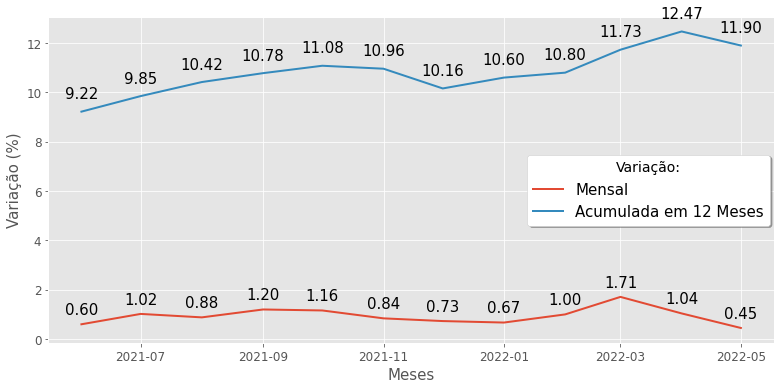

In [ ]:
inpc.iloc[-12:,[1,2]]
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(13, 6))
fig.plot(inpc.iloc[-12:,[1]], label = 'Mensal', linewidth=2)
fig.plot(inpc.iloc[-12:,[2]], label = 'Acumulada em 12 Meses', linewidth=2)
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do INPC')
plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.65,0.60),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(inpc['Variação Mensal'][-12:].index,inpc['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

for x,y in zip(inpc['Acumulado 12 meses'][-12:].index,inpc['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 3 - INPC 12M E MENSAL.svg', dpi=600)

### Acumulado no Ano

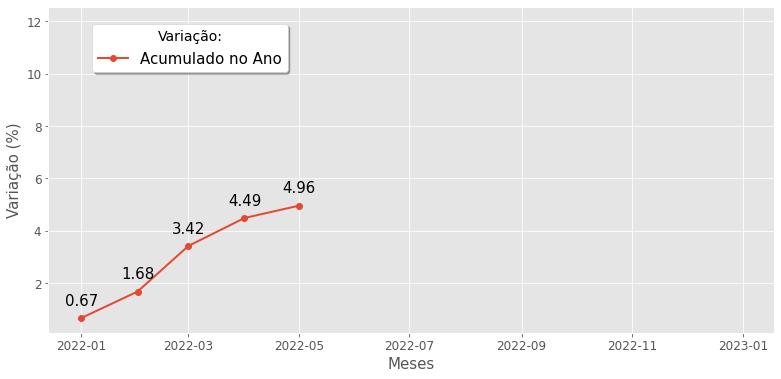

In [ ]:
inpc.iloc[-12:,[3]]

plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(13, 6))
fig.plot(inpc.iloc[410:,[3]], marker='.', markersize=12, label = 'Acumulado no Ano', linewidth=2)
fig.plot(aux_data, alpha=0)
#fig.set_title('Variação Acumulada no Ano INPC')
plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.05,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(inpc['Acumulado no Ano'][-12:].index,inpc['Acumulado no Ano'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,13), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 4 - INPC NO ANO.svg')


### INPC Regiões

In [ ]:
regioes_inpc_var_anterior = inpc_subitem_mensal_anterior[inpc_subitem_mensal_anterior.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_inpc_var_atual = inpc_subitem_mensal_atual[inpc_subitem_mensal_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_inpc_acum_atual = inpc_subitem_acum_atual[inpc_subitem_acum_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
pesos = [['RJ','POA','BH','REC','SP','DF','BEL','FOR','SAL','CUR','GOI','VIT','CG','RB','SL','AJU','NACIONAL'],
[9.30,7.15,10.35,5.60,24.60,1.97,6.95,5.16,7.92,7.37,4.43,1.91,1.73,0.72,3.47,1.29,100]]
regioes_inpc_peso_atual = pd.DataFrame(pesos)
regioes_inpc_peso_atual = regioes_inpc_peso_atual.transpose()
regioes_inpc_peso_atual.columns = ['Regiao','Peso']

In [ ]:
regioes_inpc_peso_atual = regioes_inpc_peso_atual.transpose().reset_index()
regioes_inpc_peso_atual.rename(columns={3:'Regiao',5:'Var'}, inplace=True)
regioes_inpc_peso_atual.drop(range(0,2), inplace=True)

In [ ]:
regioes_inpc_var_anterior = regioes_inpc_var_anterior.transpose().reset_index()
regioes_inpc_var_anterior.rename(columns={3:'Regiao',5:'Var ant'}, inplace=True)
regioes_inpc_var_anterior.drop(range(0,2), inplace=True)

In [ ]:
regioes_inpc_var_atual = regioes_inpc_var_atual.transpose().reset_index()
regioes_inpc_var_atual.rename(columns={3:'Regiao',5:'Var atual'}, inplace=True)
regioes_inpc_var_atual.drop(range(0,2), inplace=True)

In [ ]:
regioes_inpc_acum_atual = regioes_inpc_acum_atual.transpose().reset_index()
regioes_inpc_acum_atual.rename(columns={3:'Regiao',5:'Var acum'}, inplace=True)
regioes_inpc_acum_atual.drop(range(0,2), inplace=True)

In [ ]:
regioes_inpc_12m_atual = inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual.ITENS == ' ÍNDICE GERAL']

In [ ]:
regioes_inpc_12m_atual = regioes_inpc_12m_atual.transpose().reset_index()
regioes_inpc_12m_atual.rename(columns={3:'Regiao',5:'Var 12m'}, inplace=True)
regioes_inpc_12m_atual.drop(range(0,2), inplace=True)

In [ ]:
subitens_regioes_inpc = pd.merge(regioes_inpc_var_anterior, regioes_inpc_var_atual, how='outer') #Concatena as colunas com as variações

In [ ]:
pesos = [['RJ','POA','BH','REC','SP','DF','BEL','FOR','SAL','CUR','GOI','VIT','CG','RB','SL','AJU','NACIONAL'],
[9.30,7.15,10.35,5.60,24.60,1.97,6.95,5.16,7.92,7.37,4.43,1.91,1.73,0.72,3.47,1.29,100]]
regioes_inpc_peso_atual = pd.DataFrame(pesos)
regioes_inpc_peso_atual = regioes_inpc_peso_atual.transpose()
regioes_inpc_peso_atual.columns = ['Regiao','Peso']

In [ ]:
subitens_regioes_inpc = pd.merge(subitens_regioes_inpc, regioes_inpc_acum_atual, how='outer')

In [ ]:
subitens_regioes_inpc = pd.merge(subitens_regioes_inpc, regioes_inpc_12m_atual, how='outer')

In [ ]:
subitens_regioes_inpc = pd.merge(subitens_regioes_inpc, regioes_inpc_peso_atual, how='outer')

In [ ]:
subitens_regioes_inpc['Regiao'] = [regioes_dict[resp] for resp in subitens_regioes_inpc.Regiao]

In [ ]:
linha_brasil = subitens_regioes_inpc[subitens_regioes_inpc['Regiao'] == 'Brasil']

In [ ]:
subitens_regioes_inpc.drop(16, inplace=True)

In [ ]:
subitens_regioes_inpc.sort_values('Var atual', ascending=False, inplace=True)

In [ ]:
subitens_regioes_inpc = pd.concat([subitens_regioes_inpc, linha_brasil])

In [ ]:
workbook = oxl.load_workbook(filename='tabela_regioes.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do inpc de curitiba
for i in range(0, 17):
    sheet[f"B{i+4}"] = subitens_regioes_inpc.iloc[i,5]
    sheet[f"A{i+4}"] = subitens_regioes_inpc.iloc[i,0]
    sheet[f"C{i+4}"] = subitens_regioes_inpc.iloc[i,1]
    sheet[f"D{i+4}"] = subitens_regioes_inpc.iloc[i,2]
    sheet[f"E{i+4}"] = subitens_regioes_inpc.iloc[i,3]
    sheet[f"F{i+4}"] = subitens_regioes_inpc.iloc[i,4]


In [ ]:
workbook.save(filename="tabelas/INPC REGIÕES.xlsx")

### INPC Curitiba

Data frame com variação mensal. Ordenado do maior para o menor e possui a coluna que vai ser referencia

In [ ]:
inpc_cur_mensal_anterior = inpc_subitem_mensal_anterior[inpc_subitem_mensal_anterior.index.isin([6, 184, 224, 264, 307, 341, 386, 416, 441])]

In [ ]:
inpc_cur_mensal_atual = inpc_subitem_mensal_atual[inpc_subitem_mensal_atual.index.isin([6, 184, 224, 264, 307, 341, 386, 416, 441])]

In [ ]:
inpc_cur_acum_atual = inpc_subitem_acum_atual[inpc_subitem_acum_atual.index.isin([6, 184, 224, 264, 307, 341, 386, 416, 441])]

In [ ]:
inpc_cur_acum12m_atual = inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual.index.isin([6, 184, 224, 264, 307, 341, 386, 416, 441])]

In [ ]:
#renomear colunas
inpc_cur_mensal_anterior.rename(columns={'CUR':'CUR VAR ANT'}, inplace=True)
inpc_cur_mensal_atual.rename(columns={'CUR':'CUR VAR'}, inplace=True)
inpc_cur_acum_atual.rename(columns={'CUR':'CUR ACUM'}, inplace=True)
inpc_cur_acum12m_atual.rename(columns={'CUR':'CUR 12M'}, inplace=True)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\88639305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpc_cur_mensal_anterior.rename(columns={'CUR':'CUR VAR ANT'}, inplace=True)
C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\88639305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpc_cur_mensal_atual.rename(columns={'CUR':'CUR VAR'}, inplace=True)
C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\88639305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
subitens_cur_inpc = pd.merge(inpc_cur_mensal_anterior[['ITENS', 'CUR VAR ANT']], inpc_cur_mensal_atual[['ITENS', 'CUR VAR']], how='outer') #concatenação das colunas para uma unica tabela

In [ ]:
subitens_cur_inpc = pd.merge(subitens_cur_inpc, inpc_cur_acum12m_atual[['ITENS', 'CUR 12M']], how='outer')


In [ ]:
subitens_cur_inpc = pd.merge(subitens_cur_inpc, inpc_cur_acum_atual[['ITENS', 'CUR ACUM']], how='outer')


In [ ]:
subitens_cur_inpc = subitens_cur_inpc.sort_values('CUR VAR', ascending=False).reset_index()

In [ ]:
subitens_cur_inpc['ITENS'] = subitens_cur_inpc['ITENS'].astype(str)

In [ ]:
workbook = oxl.load_workbook(filename='tabela_curitiba.xlsx')

In [ ]:
sheet = workbook.active

In [ ]:
#Preenche a tabela das categorias do ipca de curitiba
for i in range(0, 9):
    sheet[f"A{i+4}"] = subitens_cur_inpc.iloc[i,1].strip().capitalize()
    sheet[f"B{i+4}"] = subitens_cur_inpc.iloc[i,2]
    sheet[f"C{i+4}"] = subitens_cur_inpc.iloc[i,3]
    sheet[f"D{i+4}"] = subitens_cur_inpc.iloc[i,5]
    sheet[f"E{i+4}"] = subitens_cur_inpc.iloc[i,4]


In [ ]:
workbook.save(filename="tabelas/INPC CURITIBA.xlsx")

## IPCA VS INPC

Variação do IPCA E INPC acumulado 12 meses e mensal

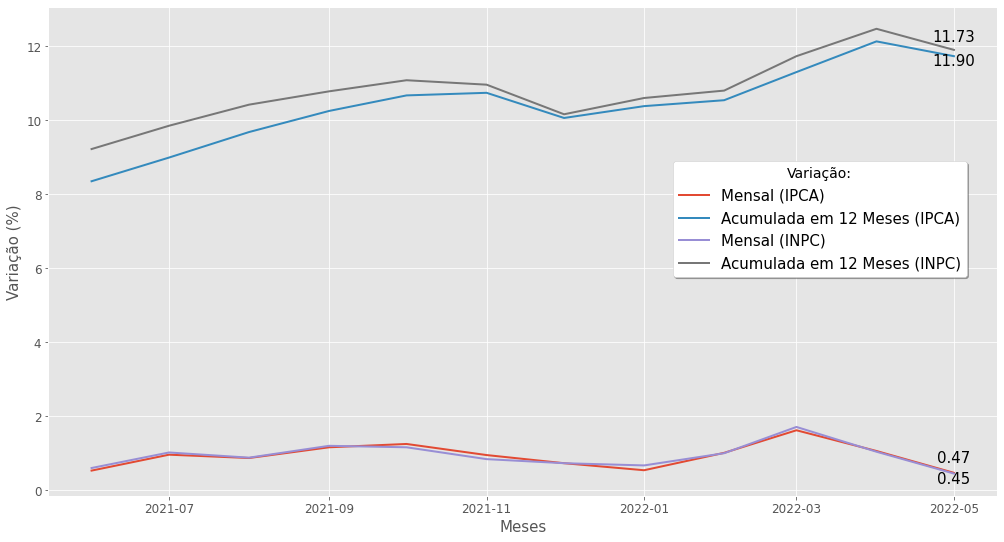

In [ ]:
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))

fig.plot(ipca.iloc[-12:,[1]], label = 'Mensal (IPCA)', linewidth=2)
fig.plot(ipca.iloc[-12:,[2]], label = 'Acumulada em 12 Meses (IPCA)', linewidth=2)

fig.plot(inpc.iloc[-12:,[1]], label = 'Mensal (INPC)', linewidth=2)
fig.plot(inpc.iloc[-12:,[2]], label = 'Acumulada em 12 Meses (INPC)', linewidth=2)

plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.65,0.70),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(ipca['Variação Mensal'][-1:].index,ipca['Variação Mensal'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

for x,y in zip(ipca['Acumulado 12 meses'][-1:].index,ipca['Acumulado 12 meses'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center',
                 size=15) # horizontal alignment can be left, right or center

# Valores em cada ponto do gráfico
for x,y in zip(inpc['Variação Mensal'][-1:].index,inpc['Variação Mensal'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,-10), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

for x,y in zip(inpc['Acumulado 12 meses'][-1:].index,inpc['Acumulado 12 meses'][-1:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,-15), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 5 - IPCA X INPC VAR 12M.svg', dpi=600)

### IPCA E INPC Preços monitorados

In [ ]:
precos_monitorados = [' ENERGIA ELÉTRICA RESIDENCIAL', ' ÓLEO DIESEL', ' PEDÁGIO', ' GÁS ENCANADO', ' TAXA DE ÁGUA E ESGOTO']
precos_monitorados_IPCA_cod = [199, 231, 232, 340, 348]
precos_monitorados_INPC_cod = [189, 221, 222, 330, 339]

In [ ]:
inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual['index'].isin(precos_monitorados_INPC_cod)].replace('       -','0', inplace=True)

C:\Users\est.matheus.brasil\AppData\Local\Temp\ipykernel_7784\3270523664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual['index'].isin(precos_monitorados_INPC_cod)].replace('       -','0', inplace=True)


In [ ]:
inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual['index'].isin(precos_monitorados_INPC_cod)].groupby(['ITENS','CUR']).sum().reset_index()

3,ITENS,CUR,index
0,ENERGIA ELÉTRICA RESIDENCIAL,28.49,222
1,GÁS ENCANADO,-,221
2,PEDÁGIO,4.57,330
3,TAXA DE ÁGUA E ESGOTO,6.89,189
4,ÓLEO DIESEL,46.89,339


In [ ]:
precos_monitorados_ipca = ipca_subitem_acum12m_atual.filter(['index','ITENS','CUR'])
precos_monitorados_ipca = ipca_subitem_acum12m_atual[ipca_subitem_acum12m_atual['index'].isin(precos_monitorados_IPCA_cod)].groupby(['ITENS','CUR']).sum().reset_index()

precos_monitorados_inpc = inpc_subitem_acum12m_atual.filter(['index','ITENS','CUR'])
precos_monitorados_inpc = inpc_subitem_acum12m_atual[inpc_subitem_acum12m_atual['index'].isin(precos_monitorados_INPC_cod)].groupby(['ITENS','CUR']).sum().reset_index()

In [ ]:
X = precos_monitorados_ipca['ITENS'].values
ipca_monitorado = precos_monitorados_ipca['CUR'].values
inpc_monitorado = precos_monitorados_inpc['CUR'].values

X_axis = np.arange(len(X))


In [ ]:
inpc_monitorado[1] = 0

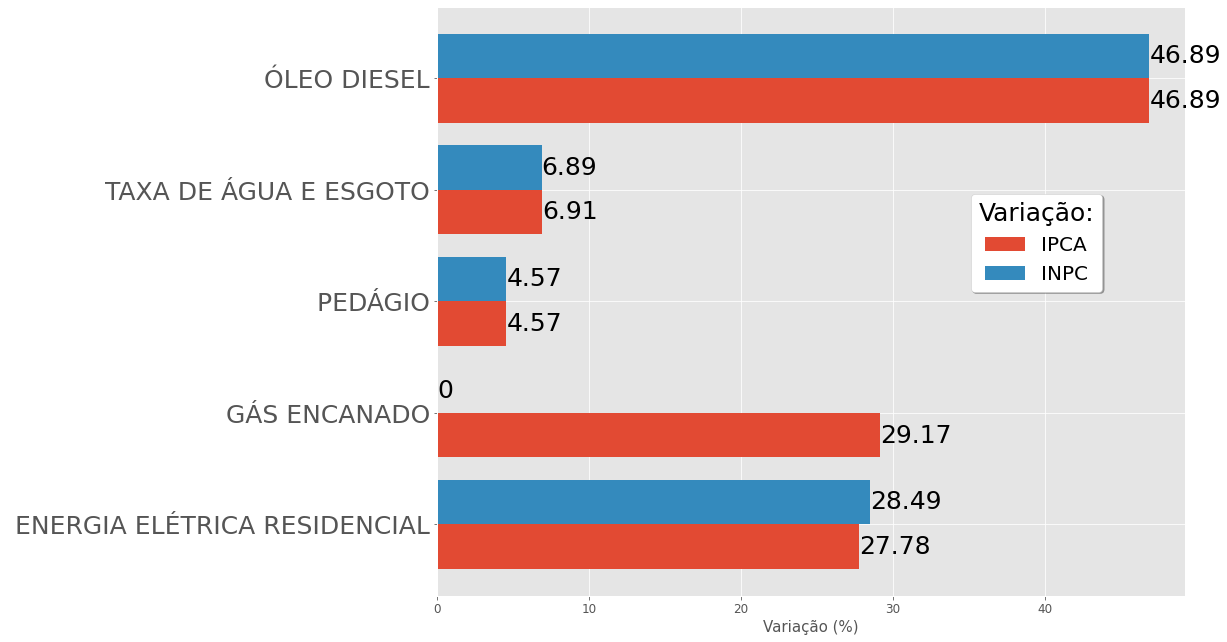

In [ ]:
ax, fig = plt.subplots(figsize=(17, 9))
baripca = plt.barh(X_axis - 0.2, ipca_monitorado, 0.4, label = 'IPCA')
barinpc = plt.barh(X_axis + 0.2, inpc_monitorado, 0.4, label = 'INPC')
plt.yticks(X_axis, X)

plt.yticks(fontsize=15)
plt.xticks(fontsize=14)

plt.bar_label(baripca, fontsize=25)
plt.bar_label(barinpc, fontsize=25)

plt.legend(
    title='Variação:',
    title_fontsize=25,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.70,0.70),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=20)
fig.set_xlabel('Variação (%)', fontsize=15)

plt.yticks(fontsize=25)
plt.xticks(fontsize=12)

plt.tight_layout(pad=1)

plt.savefig('graficos/GRÁFICO 6 - PREÇOS MONITORADOS.svg', dpi=600)

# IGP-DI

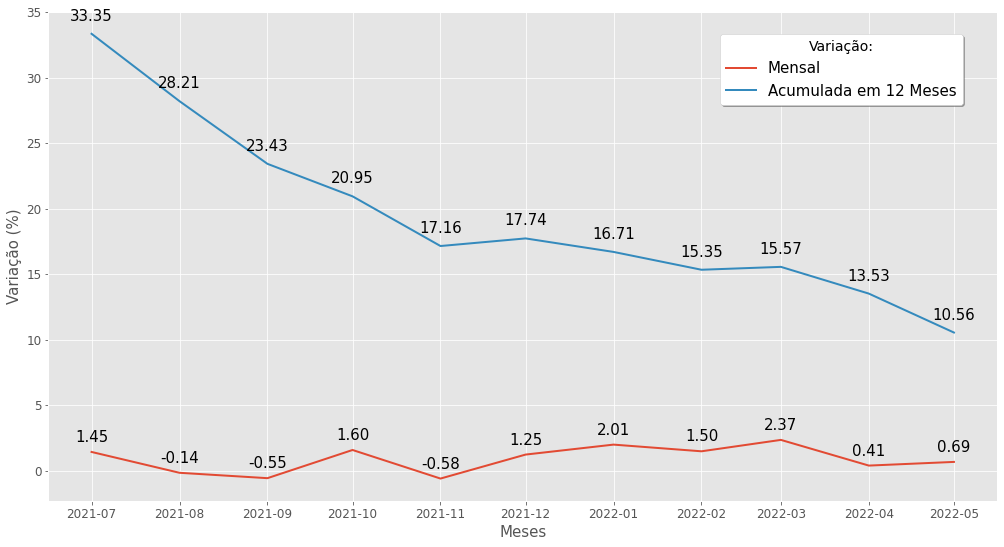

In [ ]:
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(igpdi.iloc[-11:,1], label = 'Mensal', linewidth=2)
fig.plot(igpdi.iloc[-11:,2], label = 'Acumulada em 12 Meses', linewidth=2)
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do IGP-DI')
plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.70,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(igpdi['Variação Mensal'][-12:].index,igpdi['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

for x,y in zip(igpdi['Acumulado 12 meses'][-12:].index,igpdi['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,13), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center
plt.savefig('graficos/GRÁFICO 7 - IGP-DI.svg', dpi=600)


## IGP-M

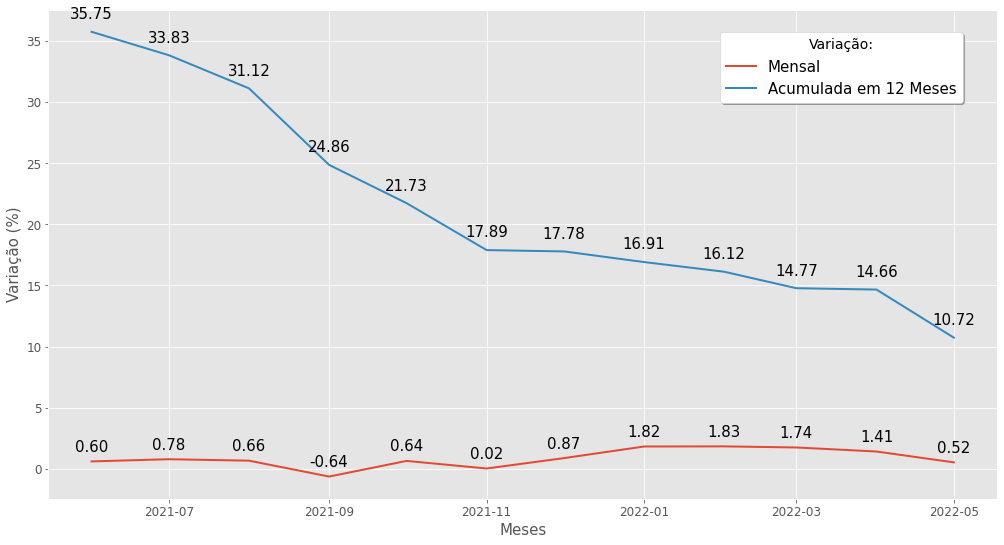

In [ ]:
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(igpm.iloc[-12:,1], label = 'Mensal', linewidth=2)
fig.plot(igpm.iloc[-12:,2], label = 'Acumulada em 12 Meses', linewidth=2)
#fig.set_title('Variação Mensal e Acumulada dos Últimos 12 meses do IGP-M')
plt.legend(
    title='Variação:',
    title_fontsize=14,
    loc='upper left',
    ncol = 1,
    bbox_to_anchor=(0.70,0.97),
    frameon=True,
    facecolor='white',
    shadow=True,
    fontsize=15)
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Variação (%)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(igpm['Variação Mensal'][-12:].index, igpm['Variação Mensal'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

for x,y in zip(igpm['Acumulado 12 meses'][-12:].index, igpm['Acumulado 12 meses'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,13), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 8 - IGP-M.svg', dpi=600)

### BRENT

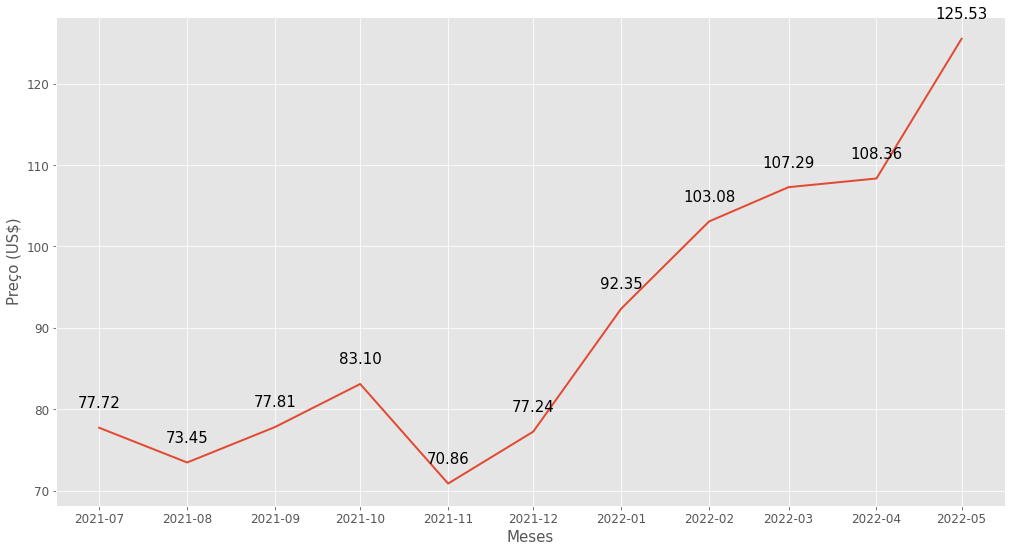

In [ ]:
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(brent.iloc[-12:,0], label = 'Mensal', linewidth=2)
#fig.set_title('Evolução do Preço por Barril de Petróleo Bruto Tipo Brent - Em US$ (FOB)')
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Preço (US$)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(brent['Preço - Brent (FOB)'][-12:].index, brent['Preço - Brent (FOB)'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,20), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 9 - BRENT.svg', dpi=600)

## Dólar

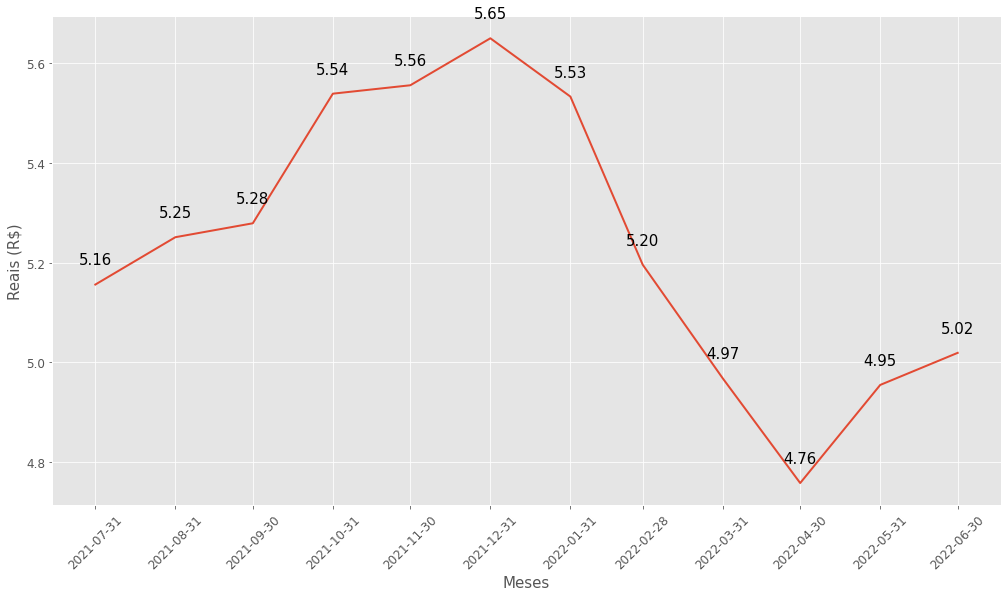

In [156]:
plt.style.use('ggplot')
ax, fig = plt.subplots(figsize=(17, 9))
fig.plot(dolar_mensal.iloc[-12:,0], label = 'Mensal', linewidth=2)
#fig.set_title('Cotação Mensal Média do Dólar em Reais - ùltimos 12 meses')
fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Reais (R$)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(dolar_mensal['valor'][-12:].index, fontsize=12, rotation=45)
# Valores em cada ponto do gráfico
for x,y in zip(dolar_mensal['valor'][-12:].index, dolar_mensal['valor'][-12:].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,20), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO - dolar.svg', dpi=600)

# DIESEL S10

In [ ]:
precos_combustiveis = precos_combustiveis.filter([
    'DATA INICIAL', 
    'DATA FINAL', 
    'REGIÃO', 
    'ESTADO', 
    'MUNICÍPIO', 
    'PRODUTO',
    'PREÇO MÉDIO REVENDA'
])

NameError: name 'precos_combustiveis' is not defined

### PREÇOS CAPITAIS 

In [ ]:
capitais = [
    'ARACAJU',
    'BELEM',
    'BELO HORIZONTE',
    'BRASILIA',
    'CAMPO GRANDE',
    'CURITIBA',
    'FORTALEZA',
    'GOIANIA',
    'PORTO ALEGRE',
    'RECIFE',
    'RIO BRANCO',
    'RIO DE JANEIRO',
    'SALVADOR',
    'SAO LUIS',
    'SAO PAULO',
    'VITORIA'
]

In [ ]:
precos_curitiba = precos_combustiveis.loc[(precos_combustiveis['MUNICÍPIO'].isin(capitais)\
    &(precos_combustiveis['PRODUTO']=='OLEO DIESEL S10')
    &(precos_combustiveis['MUNICÍPIO']=='CURITIBA'))]

In [ ]:
x = precos_curitiba.resample('M', on='DATA FINAL').mean().tail(12)

In [ ]:
x.reset_index(inplace=True)

In [ ]:
x['PREÇO MÉDIO REVENDA'] = [4.05, 3.98, 4.29, 4.30, 4.32, 4.35, 4.44, 4.80, 5.07, 5.07, 5.23, 5.371]


In [ ]:
x.set_index('DATA FINAL', inplace=True)

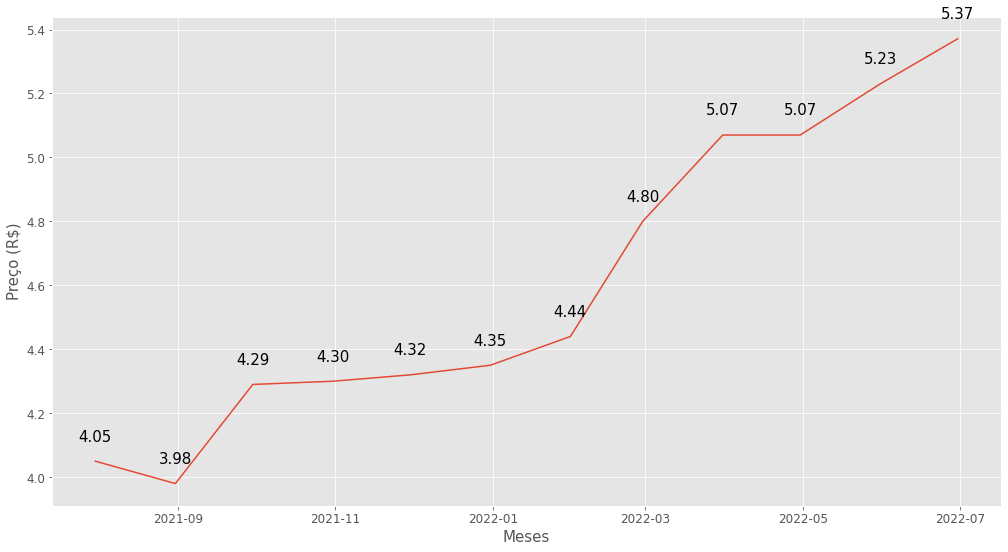

In [ ]:
ax, fig = plt.subplots(figsize=(17,9))
fig.plot(x) #variação de preço curitiba

fig.set_xlabel('Meses', fontsize=15)
fig.set_ylabel('Preço (R$)', fontsize=15)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

# Valores em cada ponto do gráfico
for x,y in zip(x['PREÇO MÉDIO REVENDA'].index, x['PREÇO MÉDIO REVENDA'].values):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                (x,y), # this is the point to label
                textcoords="offset points", # how to position the text
                xytext=(0,20), # distance from text to points (x,y)
                ha='center',
                size=15) # horizontal alignment can be left, right or center

plt.savefig('graficos/GRÁFICO 10 - DIESEL CURITIBA.svg', dpi=600)

In [ ]:
preco_diesel_regioes = precos_combustiveis.loc[(precos_combustiveis['PRODUTO']=='OLEO DIESEL S10')\
    &(precos_combustiveis['MUNICÍPIO'].isin(capitais))]

In [ ]:
tabela_regioes_precos_diesel = preco_diesel_regioes.groupby('REGIÃO').resample('M', on='DATA FINAL').mean().unstack() #variação de preço curitiba

In [ ]:
tabela_regioes_precos_diesel.iloc[:,-6]

REGIÃO
CENTRO OESTE    5.544467
NORDESTE        5.612840
NORTE           6.037400
SUDESTE         5.462450
SUL             5.285900
Name: (PREÇO MÉDIO REVENDA, 2022-01-31 00:00:00), dtype: float64

In [ ]:
tabela_regioes_precos_diesel.reset_index(inplace=True)

In [ ]:
preco_ultimo_tres_meses = tabela_regioes_precos_diesel['PREÇO MÉDIO REVENDA'].iloc[:,-3:]

In [ ]:
regioes_diesel = pd.DataFrame()

# ERRO DE KEY ERROR '' NA CELULA ABAIXO

In [ ]:
regioes_diesel['REGIÕES'] = pd.DataFrame(tabela_regioes_precos_diesel['REGIÃO']['NaT'])

KeyError: ''

In [ ]:
regioes_diesel['N-2'] = preco_ultimo_tres_meses.iloc[:,0]

: 

In [ ]:
regioes_diesel['N-1'] = preco_ultimo_tres_meses.iloc[:,1]

: 

In [ ]:
regioes_diesel['N0'] = preco_ultimo_tres_meses.iloc[:,2]

: 

In [ ]:
regioes_diesel['Media'] = (regioes_diesel['N-2'] + regioes_diesel['N-1'] + regioes_diesel['N0']) / 3

: 

In [ ]:
regioes_diesel.sort_values('Media', ascending=False)

,REGIÕES,N-2,N-1,N0,Media
2,NORTE,6.037400,6.166375,6.154000,6.119258
1,NORDESTE,5.612840,5.699900,5.678400,5.663713
0,CENTRO OESTE,5.544467,5.631833,5.661667,5.612656
3,SUDESTE,5.462450,5.610563,5.660000,5.577671
4,SUL,5.285900,5.431125,5.469500,5.395508


: 

In [ ]:
#regioes_diesel.columns = ['Regiao', 'N-2', 'N-1', 'N0', 'Media']

: 

In [ ]:
#workbook = oxl.load_workbook(filename='diesel_regioes_modelo.xlsx')

C:\Users\est.matheus.brasil\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Sparkline Group extension is not supported and will be removed
  warn(msg)


: 

In [ ]:
#sheet = workbook.active

: 

In [ ]:
# #Preenche a tabela das categorias do ipca de curitiba
# for i in range(0, 16):
#     sheet[f"A{i+4}"] = regioes_diesel['Regiao'][i]
#     sheet[f"B{i+4}"] = regioes_diesel['N-2'][i]
#     sheet[f"C{i+4}"] = regioes_diesel['N-1'][i]
#     sheet[f"D{i+4}"] = regioes_diesel['N0'][i]
#     sheet[f"E{i+4}"] = regioes_diesel['Media'][i]


: 

In [ ]:
# workbook.save(filename="tabelas/PREÇO DIESEL REGIOES.xlsx")

: 

### PREÇOS REGIÃO 

VAR ACUMULADA MENSAL; VAR ACUMULADA 6 MESES

In [ ]:
#precos_regiao = precos_combustiveis.loc[(precos_combustiveis['PRODUTO']=='OLEO DIESEL S10')]

: 

In [ ]:
#tabela_regiao_preco_medio = precos_regiao.groupby('REGIÃO').mean()
#tabela_regiao_preco_medio.reset_index(inplace=True)

: 

In [ ]:
#precos_semanais = pd.DataFrame(precos_regiao.groupby(['DATA FINAL','REGIÃO'])['PREÇO MÉDIO REVENDA'].mean())

: 

In [ ]:
# precos_regiao_centro_oeste = precos_regiao.where(precos_regiao.REGIÃO=='CENTRO OESTE').dropna()
# precos_regiao_nordeste = precos_regiao.where(precos_regiao.REGIÃO=='NORDESTE').dropna()
# precos_regiao_norte = precos_regiao.where(precos_regiao.REGIÃO=='NORTE').dropna()
# precos_regiao_suldeste = precos_regiao.where(precos_regiao.REGIÃO=='SUDESTE').dropna()
# precos_regiao_sul = precos_regiao.where(precos_regiao.REGIÃO=='SUL').dropna()

: 

In [ ]:
# preco_medio_CO = precos_regiao_centro_oeste.groupby('DATA FINAL').mean()
# preco_medio_NORD = precos_regiao_nordeste.groupby('DATA FINAL').mean()
# preco_medio_NOR = precos_regiao_norte.groupby('DATA FINAL').mean()
# preco_medio_SULD = precos_regiao_suldeste.groupby('DATA FINAL').mean()
# preco_medio_SUL = precos_regiao_sul.groupby('DATA FINAL').mean()

: 

In [ ]:
# preco_medio_CO.reset_index(inplace=True)
# preco_medio_NORD.reset_index(inplace=True)
# preco_medio_NOR.reset_index(inplace=True)
# preco_medio_SULD.reset_index(inplace=True)
# preco_medio_SUL.reset_index(inplace=True)

: 

In [ ]:
# preco_medio_CO.sort_index(ascending=False, inplace=True)
# preco_medio_NORD.sort_index(ascending=False, inplace=True)
# preco_medio_NOR.sort_index(ascending=False, inplace=True)
# preco_medio_SULD.sort_index(ascending=False, inplace=True)
# preco_medio_SUL.sort_index(ascending=False, inplace=True)

: 

In [ ]:
# preco_medio_CO.set_index('DATA FINAL', inplace=True)
# preco_medio_NORD.set_index('DATA FINAL', inplace=True)
# preco_medio_NOR.set_index('DATA FINAL', inplace=True)
# preco_medio_SULD.set_index('DATA FINAL', inplace=True)
# preco_medio_SUL.set_index('DATA FINAL', inplace=True)


: 

In [ ]:
# preco_medio_CO.reset_index(inplace=True)
# preco_medio_NORD.reset_index(inplace=True)
# preco_medio_NOR.reset_index(inplace=True)
# preco_medio_SULD.reset_index(inplace=True)
# preco_medio_SUL.reset_index(inplace=True)

: 

In [ ]:
# var_semanal_co = (preco_medio_CO['PREÇO MÉDIO REVENDA'][0] / preco_medio_CO['PREÇO MÉDIO REVENDA'][1] - 1) * 100
# var_semanal_nord = (preco_medio_NORD['PREÇO MÉDIO REVENDA'][0] / preco_medio_NORD['PREÇO MÉDIO REVENDA'][1] - 1) * 100
# var_semanal_nor = (preco_medio_NOR['PREÇO MÉDIO REVENDA'][0] / preco_medio_NOR['PREÇO MÉDIO REVENDA'][1] - 1) * 100
# var_semanal_suld = (preco_medio_SULD['PREÇO MÉDIO REVENDA'][0] / preco_medio_SULD['PREÇO MÉDIO REVENDA'][1] - 1) * 100
# var_semanal_sul = (preco_medio_SUL['PREÇO MÉDIO REVENDA'][0] / preco_medio_SUL['PREÇO MÉDIO REVENDA'][1] - 1) * 100

: 

In [ ]:
# tabela_regiao_vars = pd.DataFrame({
#     'REGIÃO':['CENTRO OESTE', 'NORDESTE', 'NORTE','SUDESTE','SUL'],
#     'VARIAÇÃO SEMANAL': [var_semanal_co,var_semanal_nord,var_semanal_nor,var_semanal_suld,var_semanal_sul]})

: 

In [ ]:
#tabela_regiao_preco_medio = pd.merge(tabela_regiao_preco_medio, tabela_regiao_vars)

: 